In [1]:
import torch as th
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from collections.abc import Callable
from typing import Any, cast
from torch.nn import Parameter, Module, MSELoss
from torch import Tensor, nn
from sklearn.datasets import make_moons
from tqdm import tqdm
from numpy import ndarray
from torchviz import make_dot

In [2]:
class RAI(Module):
    _func: Module # The function/module to call
    _loss_fn: Module # Loss function to compute the intermeldiate loss

    def __init__(self, func: Module, loss: Module = MSELoss()) -> None:
        super().__init__()
        self._func = func
        self._loss_fn = loss
    
    def forward(self, *arg: Any, **kwg: Any) -> th.Tensor:
        pred = cast(Callable[..., th.Tensor], self._func)
        if self.training:
            if not hasattr(self, "cache"):
                self.cache = Parameter(pred(*arg, **kwg).detach())
            self.loss = self._loss_fn(self.cache, pred(*arg, **kwg))
            return self.cache
        return pred(*arg, **kwg)

In [3]:
class LossFn(Module):
    _func: Module # The function/module to call
    _loss_fn: Module # Loss function to compute the output head's loss

    def __init__(self, func: Module, loss: Module = MSELoss()) -> None:
        super().__init__()
        self._func = func
        self._loss_fn = loss

    def forward(self, y: Tensor, *arg: Any, **kwg: Any) -> th.Tensor:
        pred = cast(Callable[..., th.Tensor], self._func)
        loss = self._loss_fn(pred(*arg, **kwg), y)
        for m in self.modules():
            if hasattr(m, "loss"):
                loss += m.loss
        return loss

In [4]:
def fit(func: Module, optcls: type[th.optim.Optimizer], x: Tensor, y: Tensor, num_itr: int, show: bool = True, **kws: Any) -> tuple[float, ...]:
    func.train(True)
    try:
        func(y, x)
        optim = optcls(func.parameters(), **kws)
        for _ in (bar := tqdm(range(num_itr), unit="itr", disable=not show)):
            optim.zero_grad()
            (loss := func(y, x)).backward()
            optim.step()
            bar.set_description(f"L{loss.item():.4f}")
    finally:
        func.train(False)

In [5]:
x, y = cast(tuple[ndarray[Any, Any], ...], make_moons(n_samples=100, noise=0.1, random_state=42))
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32).unsqueeze(1)
x[:5], y[:5]

(tensor([[ 1.5820, -0.4458],
         [ 0.0660,  0.4392],
         [ 0.7366, -0.3990],
         [-1.0569,  0.2425],
         [-0.8022,  0.2027]]),
 tensor([[1.],
         [1.],
         [1.],
         [0.],
         [0.]]))

In [6]:
def landscape(func: Callable[[float, float], float], 
              low: tuple[float, float] = (-1.0, -1.0),
              high: tuple[float, float] = (+1.0, +1.0),
              resolution: int = 100,
              cmap: str = 'viridis',
              alpha: float = 0.7,
              title: str = 'Function Lascape',
              data: tuple[Any, Any] | None = None,
              figsize: tuple[int, int] = (10, 8),
              show: bool = True) -> tuple[Figure, Axes]:
    x_range = (low[0], high[0])
    y_range = (low[1], high[1])

    fig, ax = plt.subplots(figsize=figsize)
    
    x_min, x_max = x_range
    y_min, y_max = y_range
    x_grid = np.linspace(x_min, x_max, resolution)
    y_grid = np.linspace(y_min, y_max, resolution)
    XX, YY = np.meshgrid(x_grid, y_grid)
    
    ZZ = np.zeros_like(XX)
    for i in range(resolution):
        for j in range(resolution):
            ZZ[i, j] = func(XX[i, j], YY[i, j])
    
    im = ax.pcolormesh(XX, YY, ZZ, cmap=cmap, alpha=alpha, shading='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Function Value')
    
    if data is not None:
        X, y = data
        if isinstance(X, th.Tensor):
            X = X.detach().cpu().numpy()
        if isinstance(y, th.Tensor):
            y = y.detach().cpu().numpy()
        
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.squeeze()
            
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, 
                           edgecolors='k', s=80, alpha=0.8)
        
        if len(np.unique(y)) <= 10:
            ax.legend(*scatter.legend_elements(), title="Classes")
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    
    plt.tight_layout()
    
    if show:
        plt.show()
    
    return fig, ax

In [7]:
def visualize_model_graph(model_name: str, model: Module, x_sample: Tensor, y_sample: Tensor | None =None) -> None:
    """
    Visualizes the computational graph of a model.
    
    Args:
        model_name: Name for the output file
        model: The PyTorch model
        x_sample: Input sample tensor
        y_sample: Optional target for loss computation
    """
    model.train(True)  # Set to training mode to see all computations
    try:
        if y_sample is not None:
            # For loss function wrapped models
            loss_fn = LossFn(model, nn.BCELoss())
            out = loss_fn(y_sample, x_sample)
            filename = f"{model_name}"
        else:
            # For direct model visualization
            out = model(x_sample)
            filename = model_name
        
        # Create the graph visualization
        dot = make_dot(
            out, 
            params=dict(list(model.named_parameters())),
            show_attrs=True,
            show_saved=True
        )
        
        # Customize graph appearance
        dot.attr('graph', rankdir='LR', size="40,20")  # Left to right layout
        dot.attr('node', fontsize='18')
        
        # Render and save the graph
        dot.render(filename, format='png', cleanup=True)
    finally:
        model.train(False)  # Set back to evaluation mode
    return dot

In [8]:
class MLP(Module):
    mlp: Module

    def __init__(self, widths: list[int]):
        super().__init__()
        assert 2 < len(widths), f"Need at least input and output dimensions; got {widths}"
        self.mlp = nn.Sequential()
        for i in range(len(widths) - 1):
            self.mlp.append(nn.Linear(widths[i], widths[i + 1]))
            if i < len(widths) - 2:
                self.mlp.append(nn.ReLU())
        self.mlp.append(nn.Sigmoid())
    
    def forward(self, x: Tensor) -> Tensor:
        return self.mlp(x)

In [9]:
mlp = MLP([2, 42, 100, 42, 1])
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=42, bias=True)
    (5): ReLU()
    (6): Linear(in_features=42, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [10]:
fit(LossFn(mlp, nn.BCELoss()), th.optim.Rprop, cast(Tensor, x), cast(Tensor, y), num_itr=100, lr=0.1)

L0.0000: 100%|██████████| 100/100 [00:00<00:00, 199.05itr/s]


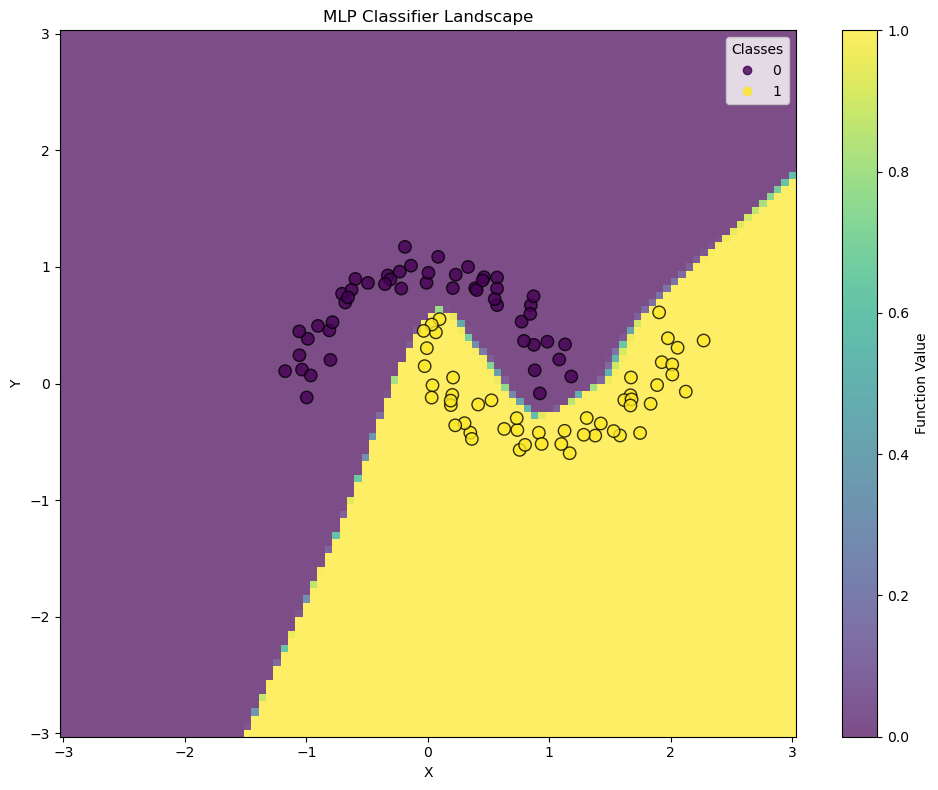

In [11]:
def fn_mlp(x: float, y: float) -> float:
    """Function to evaluate the MLP classifier."""
    with th.no_grad():
        return mlp(th.tensor([[x, y]], dtype=th.float32)).item()

landscape(fn_mlp, low=(-3., -3.), high=(3., 3.), resolution=100, cmap='viridis', alpha=0.7, title='MLP Classifier Landscape', data=(x, y));

In [12]:
class RAI_MLP(Module):
    mlp: Module

    def __init__(self, widths: list[int]):
        super().__init__()
        assert 2 < len(widths), f"Need at least input and output dimensions; got {widths}"
        self.mlp = nn.Sequential()
        for i in range(len(widths) - 1):
            self.mlp.append(RAI(nn.Linear(widths[i], widths[i + 1])))
            if i < len(widths) - 2:
                self.mlp.append(nn.ReLU())
        self.mlp.append(nn.Sigmoid())
    
    def forward(self, x: Tensor) -> Tensor:
        return self.mlp(x)

In [ ]:
rai_mlp = RAI_MLP([2, 42, 100, 100, 42, 1])
rai_mlp

RAI_MLP(
  (mlp): Sequential(
    (0): RAI(
      (_func): Linear(in_features=2, out_features=42, bias=True)
      (_loss_fn): MSELoss()
    )
    (1): ReLU()
    (2): RAI(
      (_func): Linear(in_features=42, out_features=100, bias=True)
      (_loss_fn): MSELoss()
    )
    (3): ReLU()
    (4): RAI(
      (_func): Linear(in_features=100, out_features=100, bias=True)
      (_loss_fn): MSELoss()
    )
    (5): ReLU()
    (6): RAI(
      (_func): Linear(in_features=100, out_features=42, bias=True)
      (_loss_fn): MSELoss()
    )
    (7): ReLU()
    (8): RAI(
      (_func): Linear(in_features=42, out_features=1, bias=True)
      (_loss_fn): MSELoss()
    )
    (9): Sigmoid()
  )
)

In [14]:
fit(LossFn(rai_mlp, nn.BCELoss()), th.optim.Rprop, cast(Tensor, x), cast(Tensor, y), num_itr=10000, lr=0.1)

L0.0003: 100%|██████████| 10000/10000 [01:30<00:00, 110.46itr/s]


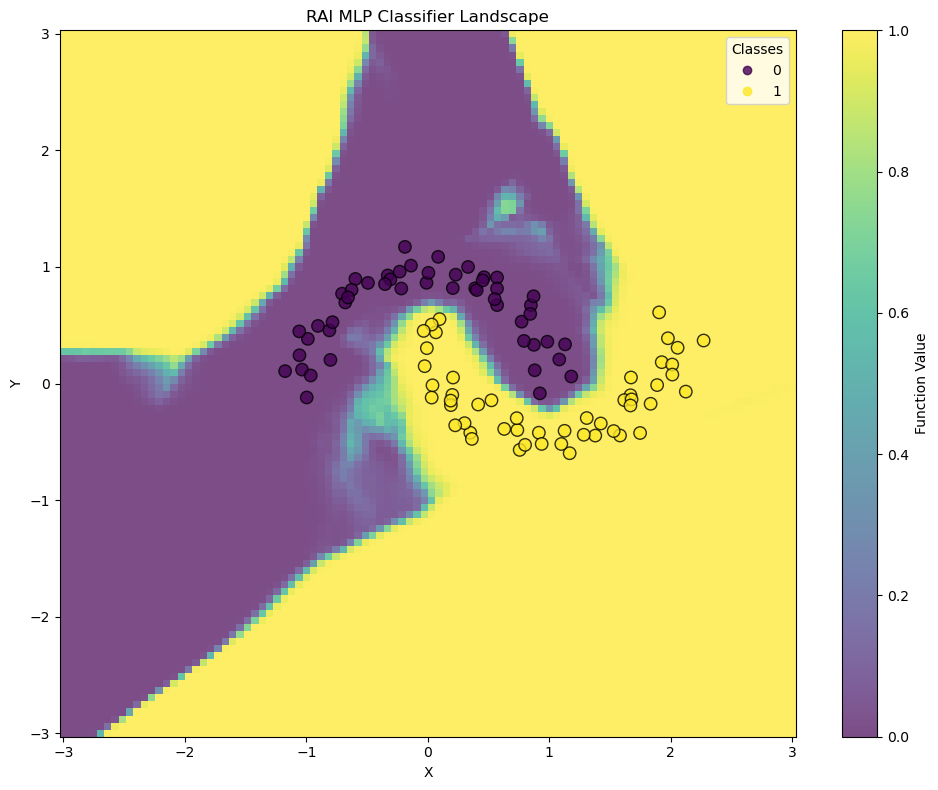

In [15]:
def fn_emlp(x: float, y: float) -> float:
    """Function to evaluate the MLP classifier."""
    with th.no_grad():
        return rai_mlp(th.tensor([[x, y]], dtype=th.float32)).item()

landscape(fn_emlp, low=(-3., -3.), high=(3., 3.), resolution=100, cmap='viridis', alpha=0.7, title='RAI MLP Classifier Landscape', data=(x, y));

In [16]:
mlp_graph = visualize_model_graph("mlp_graph", mlp, cast(Tensor, x), cast(Tensor, y))
rai_mlp_graph = visualize_model_graph("rai_mlp_graph", rai_mlp, cast(Tensor, x), cast(Tensor, y))

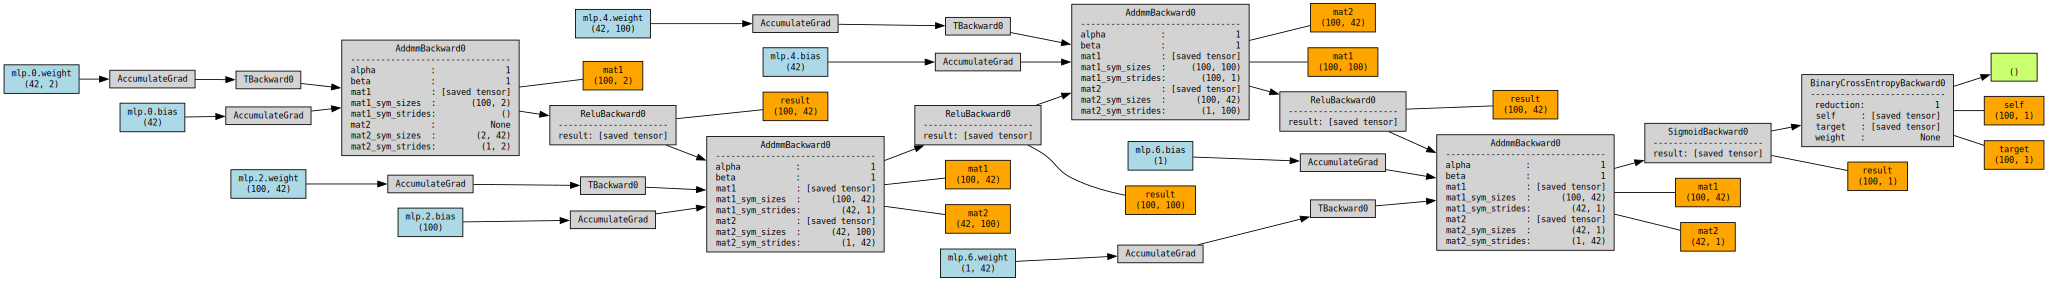

In [17]:
mlp_graph

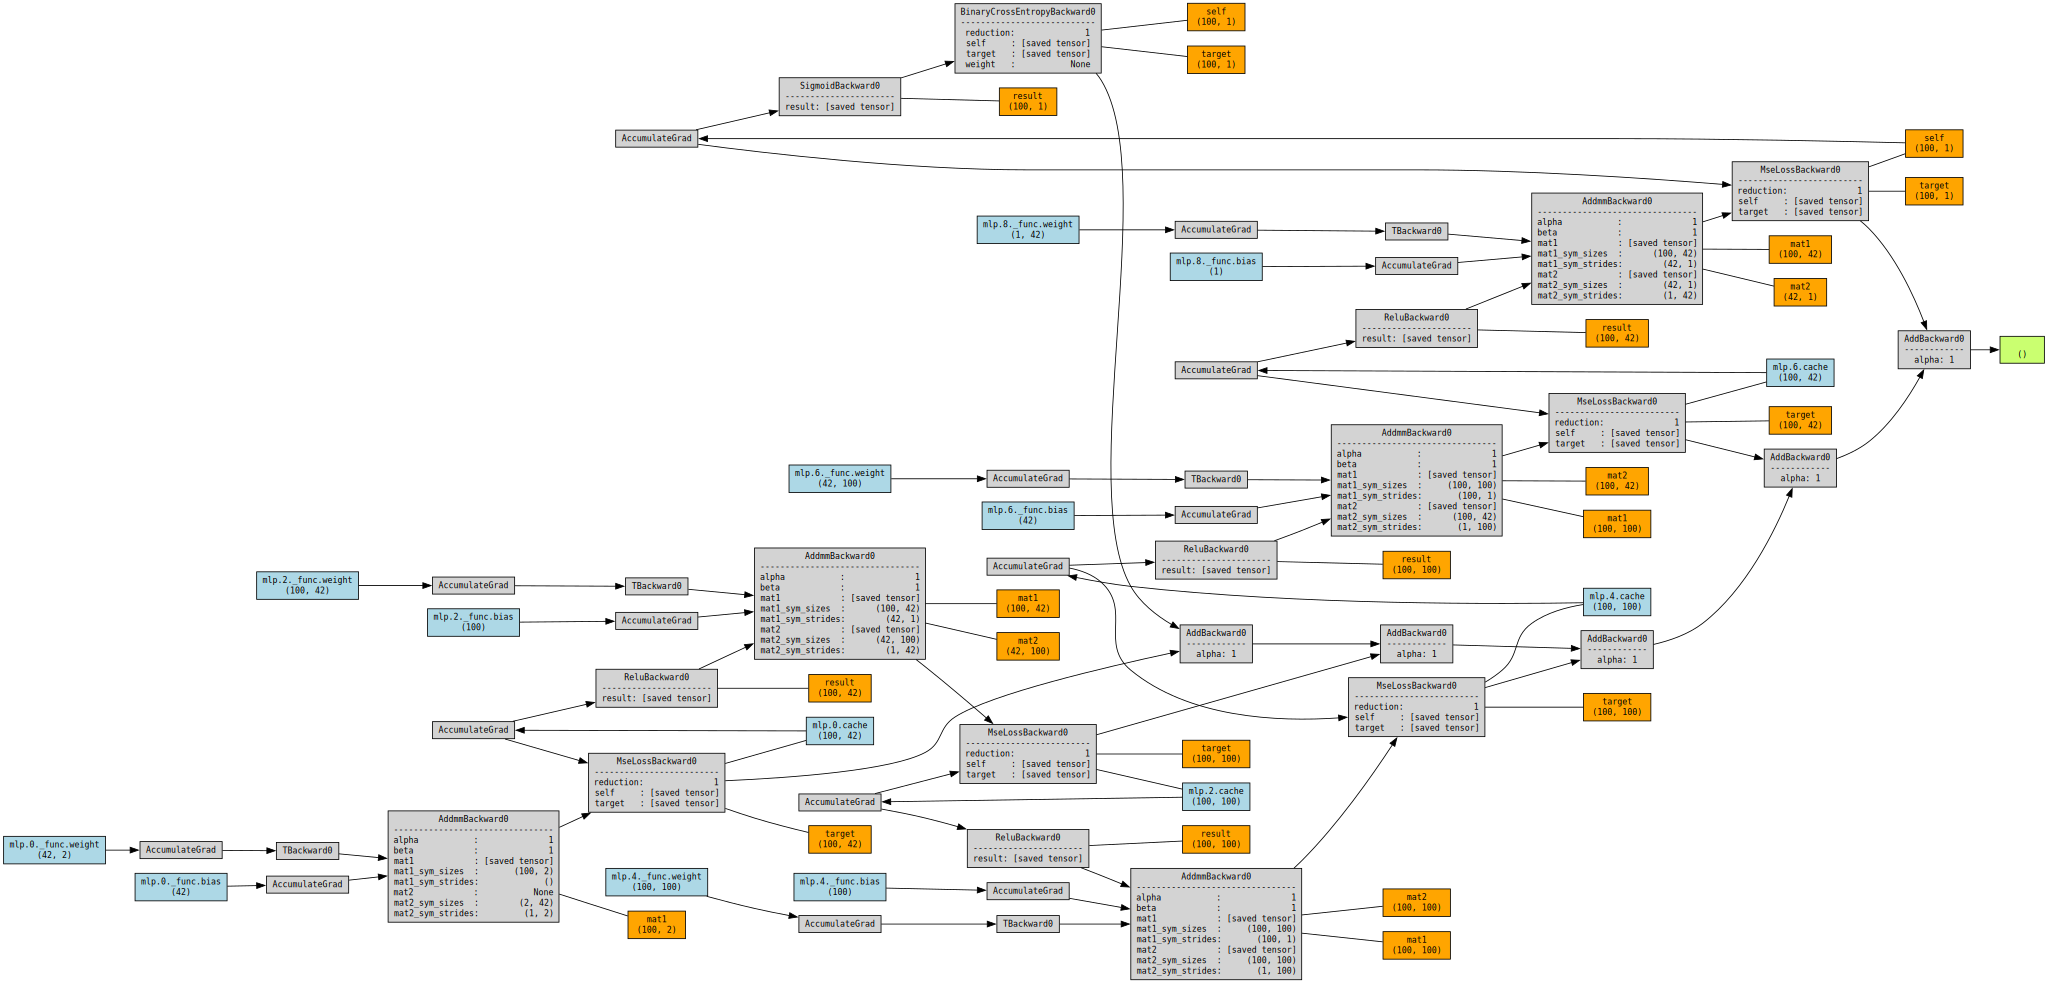

In [18]:
rai_mlp_graph